In [209]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

In [210]:
df = pd.read_csv(r"C:\Users\Laptop MD\OneDrive\Tai lieu\N3-2_Risk Management\asm2_data.csv") 
df

,Date,VIB,MSN,VIC,HDB
0,20210104,16.7084,72.7990,96.0000,15.4524
1,20210105,17.8730,73.1266,97.5111,15.8692
2,20210106,17.8983,72.3077,97.9556,16.4463
3,20210107,17.7211,75.3376,97.8667,17.1836
4,20210108,17.5945,76.2384,99.3778,17.3760
...,...,...,...,...,...
494,20221226,17.5598,91.5000,52.6000,16.2500
495,20221227,18.1818,91.6000,53.4000,16.3500
496,20221228,18.1818,93.0000,53.5000,16.2000
497,20221229,18.0861,94.0000,53.6000,15.9000


In [211]:
df[['Date']] = df[['Date']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[4:6],s[6:], s[0:4]))
df.head()

,Date,VIB,MSN,VIC,HDB
0,01/04/2021,16.7084,72.7990,96.0000,15.4524
1,01/05/2021,17.8730,73.1266,97.5111,15.8692
2,01/06/2021,17.8983,72.3077,97.9556,16.4463
3,01/07/2021,17.7211,75.3376,97.8667,17.1836
4,01/08/2021,17.5945,76.2384,99.3778,17.3760


In [212]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,VIB,MSN,VIC,HDB
0,2021-01-04,16.7084,72.7990,96.0000,15.4524
1,2021-01-05,17.8730,73.1266,97.5111,15.8692
2,2021-01-06,17.8983,72.3077,97.9556,16.4463
3,2021-01-07,17.7211,75.3376,97.8667,17.1836
4,2021-01-08,17.5945,76.2384,99.3778,17.3760


In [213]:
df = df.set_index('Date')

In [214]:
df.head()

,VIB,MSN,VIC,HDB
Date,,,,
2021-01-04,16.7084,72.7990,96.0000,15.4524
2021-01-05,17.8730,73.1266,97.5111,15.8692
2021-01-06,17.8983,72.3077,97.9556,16.4463
2021-01-07,17.7211,75.3376,97.8667,17.1836
2021-01-08,17.5945,76.2384,99.3778,17.3760


Text(0, 0.5, 'price in $')

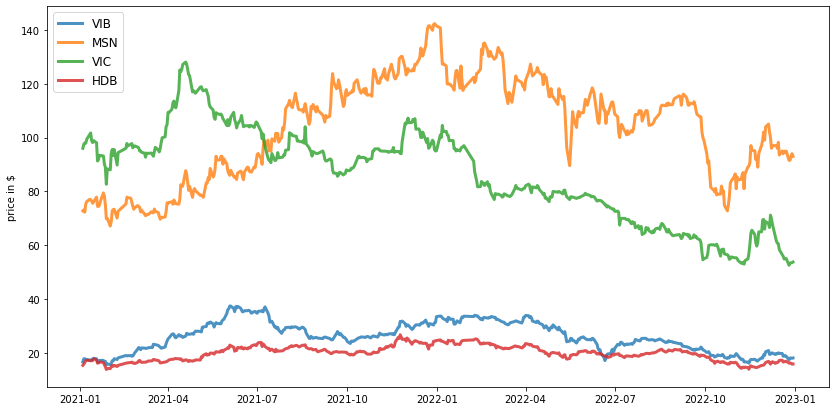

In [215]:
plt.figure(figsize=(14, 7))
for c in df.columns.values:
    plt.plot(df.index, df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

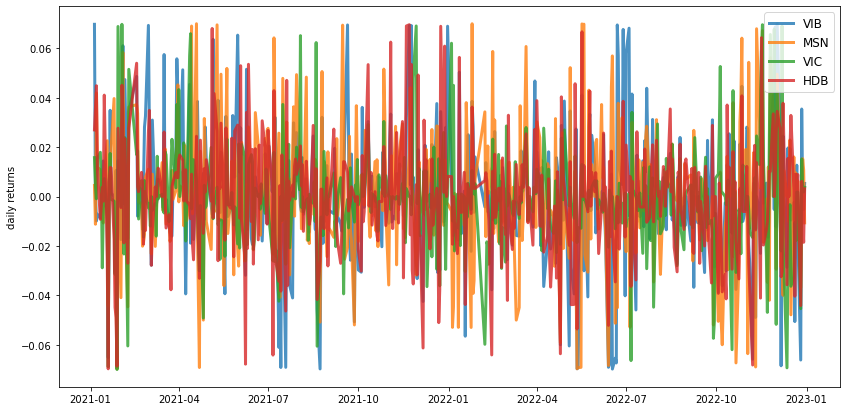

In [216]:
returns = df.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [217]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *499
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(499)
    return std, returns

In [218]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [219]:
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [222]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [223]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [224]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [225]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*200)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*200)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.xlim(right=0.55)
    # tangent line
    x = [0, risk_free_rate]
    y = [sdp, rp]
# tangent line
    point1 = [0, risk_free_rate]
    point2 = [sdp, rp]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot((point1[0],point2[0] ),(point1[1],point2[1] ))
    
    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.37
Annualised Volatility: 0.5


             VIB   MSN  VIC  HDB
allocation  25.4  74.6  0.0  0.0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.08
Annualised Volatility: 0.37


              VIB    MSN    VIC    HDB
allocation  14.04  18.07  46.67  21.23


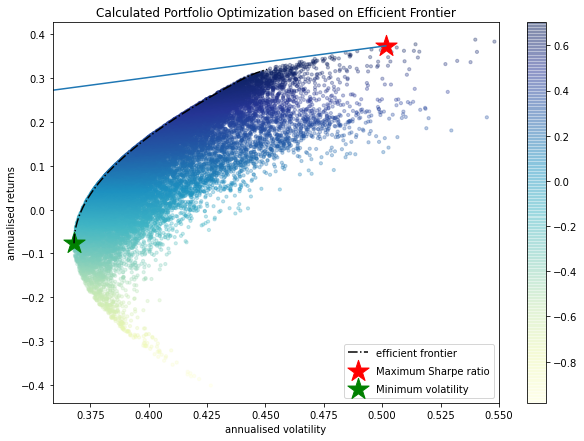

In [226]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [227]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(df.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(df.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    
    #plt.xlim(right=0.55)
    # tangent line
    x = [0, risk_free_rate]
    y = [sdp, rp]
    
    coefficients = np.polyfit(x, y, 1)
    # Print the findings
    print('a =', coefficients[0])
    print('b =', coefficients[1])

    # Let's compute the values of the line...
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(0,500,100)
    y_axis = polynomial(x_axis)
    
    x_values = [x[0], y[0]]
    y_values = [x[1], y[1]]
    plt.plot(x_values, y_values, 'red')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.37
Annualised Volatility: 0.5


             VIB   MSN  VIC  HDB
allocation  25.4  74.6  0.0  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.08
Annualised Volatility: 0.37


              VIB    MSN    VIC    HDB
allocation  14.04  18.07  46.67  21.23
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

VIB : annuaised return 0.13 , annualised volatility: 0.41
MSN : annuaised return 0.21 , annualised volatility: 0.41
VIC : annuaised return -0.24 , annualised volatility: 0.32
HDB : annuaised return 0.08 , annualised volatility: 0.37
--------------------------------------------------------------------------------
a = -7.182653827511809
b = 0.5015372640653295


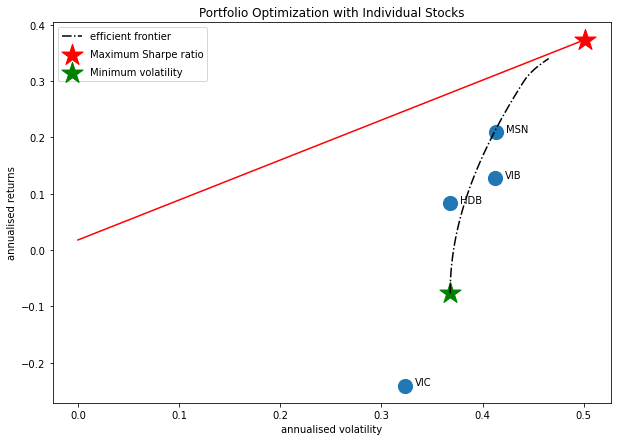

In [229]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)